# 🧬 Embedding with Hi-Cformer on Wu2024 Dataset

This notebook demonstrates how to train the **Hi-Cformer** model on single-cell Hi-C data, using per-chromosome sparse contact matrices as input.  
The model learns **cell embeddings**, supporting downstream tasks such as visualization.



## 📁 Input Files

### 🔹 1. Sparse Contact Matrix Folder

Each `.npy` file contains a **sparse adjacency matrix** for one chromosome.  
These matrices are typically saved in coordinate (COO) or compressed sparse row (CSR) format.

**Example path:**

```
/home/scHi-C_dataset/Wu2024_GSE240128/raw/
```

**Example contents:**

- `chr1_sparse_adj.npy`  
- `chr2_sparse_adj.npy`  
- ...

Each matrix corresponds to a single chromosome across all cells, preprocessed at a fixed resolution.


### 🔹 2. Model Configuration File (`config.json`)

This JSON file stores model architecture settings and training hyperparameters.

**Example content:**

```json
{
  "pretrain_epoch": 150,
  "loss_ratio": 0.02,
  "embed_dim": 128,
  "num": 0,
  "depth": 4,
  "pretrain": true,
  "hidden_dim": 64,
  "vis": true,
  "batch_size": 32,
  "weight_decay": 0.0,
  "epochs": 180,
  "betas": [0.9, 0.999],
  "patience": 10,
  "learning rate": 0.0005,
  "chr_single_loss": true,
  "encoder_dim": [],
  "weight": 0.1,
  "patch_size": [8, 16, 32, 64, 128],
  "chr_single_ratio": 0.5,
  "mask_ratio": 0.4,
  "atlr": 0.0005,
  "otherlf": "MSE",
  "enorm": false
}
```

This file is parsed at runtime to dynamically initialize the Hi-Cformer model and training loop.



### 🔹 3. Optional: Metadata File (`label_info.pickle`)

This file stores metadata for each cell, such as **cell type** and **batch**, in the form of a dictionary of lists.  
It is used **only during validation and visualization**, for tasks such as:

- Coloring UMAP/t-SNE plots  
- Evaluating embedding quality 

**Expected format:**

```python
{
  "name": ["GSM7682144_BJ_cell_041", "GSM7682258_eHAP_029", ...],
  "cell type": ["BJ", "eHAP", ...],
  "batch": ["Batch1", "Batch2", ...]
}
```

Each list should be of the same length, with aligned entries.




## 🛠️ Workflow Overview

1. **Data Loading & Model Initialization**  
   Load per-chromosome `.npy` sparse matrices and parse model configuration. Dynamically build Hi-Cformer using parameters in the JSON file.

3. **Training**  
   Train on sparse Hi-C contact maps using appropriate loss functions.

4. **Validation & Visualization**  
   The model’s learned embeddings are visualized using UMAP, with cells colored by labels from label_info.pickle.



## Data loading & model initialization

In [5]:
import os
import json
import pickle
import time
from functools import partial

import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from hicformer.model import hicformer
from hicformer.utils import cal_expand_tensor

# === Configuration ===
# meta_data file and label key
label_path = "/home/wuxiaoqing/scHi-C_dataset/Wu2024_GSE240128/label_info.pickle"
label_name = "cell type"

# sparse contact map folder
raw_path = "/home/wuxiaoqing/scHi-C_dataset/Wu2024_GSE240128/init_higashi/raw"
# chromosome list of input
chr_list = ['chr1', 'chr2',  'chr3', 'chr4','chr5', 'chr6','chr7','chr10','chr8','chr14',
             'chr11', 'chr13', 'chr12', 'chr15', 'chr16','chr17',  'chr18', 'chr19', 'chr20', 'chr21', 'chr22','chrX']

# model configure file
config_path = "/home/wuxiaoqing/Hi-Cformer/demo/hicformer_params_0.json"

# === Load Labels ===
with open(label_path, 'rb') as file:
    datas = pickle.load(file)
labels = datas[label_name]
new_label = list(labels)
cell_num = len(new_label)

# === Load Model Config ===
with open(config_path, 'r') as f:
    args = json.load(f)

def str2bool(x):
    return x if isinstance(x, bool) else x.lower() == 'true'

# Parse and fix parameters
pretrain = str2bool(args.get("pretrain", True))
vis = str2bool(args.get("vis", True))
chr_single_loss = str2bool(args.get("chr_single_loss", True))
enorm = str2bool(args.get("enorm", False))
patch_size = args.get("patch_size", [8, 16, 32, 64, 128])
embed_dim = args.get("embed_dim", 128)

# === Load Data ===
all_pics = []
chr_cls = []
max_height = 0

for chrname in chr_list:
    f = os.path.join(raw_path, chrname + '_sparse_adj.npy')
    loaded_data = np.load(f, allow_pickle=True)

    mats = [mat.toarray() for mat in loaded_data]
    datas = np.array(mats)
    max_height = max(max_height, datas.shape[1])

    datas_flat = datas.reshape(datas.shape[0], -1)
    onechr_pic = torch.stack([torch.tensor(pic, dtype=torch.float32).unsqueeze(0) for pic in mats])
    all_pics.append(onechr_pic)

    pca = PCA(n_components=embed_dim, random_state=3)
    result = pca.fit_transform(datas_flat)
    if enorm:
        result = StandardScaler().fit_transform(result)
    chr_cls.append(result)
    print(f"Processed {chrname}")

# Stack chromosome-level embeddings
chr_tensor = torch.stack([torch.from_numpy(arr) for arr in chr_cls], dim=1)
whole_size = sum(cal_expand_tensor(item) for item in all_pics)
num_patches = max_height // min(patch_size)

# === Construct Model ===

allowed_model_keys = {
    "whole_size", "img_size", "hidden_dim", "patch_size", "encoder_dim", "chr_num", "in_chans",
    "embed_dim", "depth", "num_heads", "mlp_ratio", "norm_layer", "chr_mutual_visibility",
    "weight", "chr_single_loss", "num_patches", "otherlf", "enorm", "weight_mode"
}


model_kwargs = {
    key: val for key, val in {
        "whole_size": whole_size,
        "img_size": args.get("img_size", max_height),
        "patch_size": patch_size,
        "encoder_dim": args.get("encoder_dim", []),
        "hidden_dim": args.get("hidden_dim", 64),
        "embed_dim": embed_dim,
        "depth": args.get("depth", 4),
        "chr_num": len(chr_list),
        "in_chans": 1,
        "num_heads": 8,
        "mlp_ratio": 4.0,
        "norm_layer": partial(nn.LayerNorm, eps=1e-6),
        "chr_mutual_visibility": vis,
        "weight": args.get("weight", 0.1),
        "chr_single_loss": chr_single_loss,
        "num_patches": num_patches,
        "otherlf": args.get("otherlf", 'MSE'),
        "enorm": enorm,
        "weight_mode": args.get("weight_mode", 'mask'),
    }.items() if key in allowed_model_keys
}


model = hicformer(**model_kwargs)
device = torch.device(f"cuda:{args.get('cuda', 1)}" if torch.cuda.is_available() else "cpu")
model.to(device)

# === Calculate Average Contact for Each Cell ===
cell_feats1 = torch.zeros((cell_num, 1), dtype=torch.float32)
for i in range(cell_num):
    total_sum = 0
    total_count = 0
    for chrom_matrix in all_pics:
        mat = chrom_matrix[i, :, :]
        vals = mat[mat > 0]
        total_sum += vals.sum().item()
        total_count += vals.numel()
    cell_feats1[i, 0] = total_sum / total_count if total_count > 0 else 0

# === Create Dataset ===
all_pics.append(chr_tensor)
all_pics.append(cell_feats1)
dataset = TensorDataset(*all_pics)
data_loader_train = DataLoader(dataset, batch_size=args.get("batch_size", 32), shuffle=True)
data_loader_test = DataLoader(dataset, batch_size=16, shuffle=False)

print(model)



Processed chr1
Processed chr2
Processed chr3
Processed chr4
Processed chr5
Processed chr6
Processed chr7
Processed chr10
Processed chr8
Processed chr14
Processed chr11
Processed chr13
Processed chr12
Processed chr15
Processed chr16
Processed chr17
Processed chr18
Processed chr19
Processed chr20
Processed chr21
Processed chr22
Processed chrX
hicformer(
  (multi_encoder): ModuleList(
    (0): block_encoder(
      (proj): Conv2d(1, 128, kernel_size=(8, 8), stride=(8, 8))
      (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): block_encoder(
      (proj): Conv2d(1, 128, kernel_size=(16, 16), stride=(16, 16))
      (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
    )
    (2): block_encoder(
      (proj): Conv2d(1, 128, kernel_size=(32, 32), stride=(32, 32))
      (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
    )
    (3): block_encoder(
      (proj): Conv2d(1, 128, kernel_size=(64, 64), stride=(64, 64))
      (norm): LayerNorm((128,

## Training

In [6]:
print("Start training")

pretrain_epoch = args.get("pretrain_epoch", 150)
epochs = args.get('epochs', 180)
loss_ratio = args.get("loss_ratio", 0.02)
chr_single_ratio = args.get("chr_single_ratio", 0.5)
mask_ratio = args.get("mask_ratio", 0.5)
patience = args.get("patience", 10)

best_nmi = float("-inf")
best_loss = float("inf")
patience_count = 0

if pretrain:
    # chr_pretrain
    optimizer_chr = torch.optim.Adam(model.parameters(), lr=args.get("learning rate", 5e-4),
                             weight_decay=args.get("weight_decay", 0.0), betas=tuple(args.get("betas", [0.9, 0.999])))
    for epoch in range(pretrain_epoch):
        model.train()
        epoch_loss, epoch_chr_loss, epoch_chr_single_loss = 0, 0, 0
        
        for inputs in data_loader_train:
            inputs = [item.to(device) for item in inputs]
            optimizer_chr.zero_grad()
            chr_loss, chr_single_loss = model.aepretrain(inputs)
            loss = chr_loss  
            loss.backward()
            optimizer_chr.step()
            
            epoch_loss += loss.item()
            epoch_chr_loss += chr_loss.item()
            if model.chr_single_loss:
                epoch_chr_single_loss += chr_single_loss.item()
            else:
                epoch_chr_single_loss += chr_single_loss
        
        avg_loss = epoch_loss / len(data_loader_train)
        print(f"Pretrain Phase1 Epoch {epoch+1}/{pretrain_epoch}, Chr Loss: {epoch_chr_loss/len(data_loader_train):.4f}")
        
        # Early stopping logic
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_count = 0
            best_state = model.state_dict()
        else:
            patience_count += 1
            if patience_count > patience:
                print("Early stopping at pretrain phase 1")
                break
    

    model.load_state_dict(best_state)

    # patch_pretrain
    optimizer_patch = torch.optim.Adam(model.parameters(), lr=args.get("learning rate", 5e-4),
                             weight_decay=args.get("weight_decay", 0.0), betas=tuple(args.get("betas", [0.9, 0.999])))
    best_loss = float("inf")
    patience_count = 0
    
    for epoch in range(pretrain_epoch):
        model.train()
        epoch_loss = 0
        for inputs in data_loader_train:
            inputs = [item.to(device) for item in inputs]
            optimizer_patch.zero_grad()
            chr_loss = model.patch_pretrain(inputs)
            chr_loss.backward()
            optimizer_patch.step()
            epoch_loss += chr_loss.item()
        
        avg_loss = epoch_loss / len(data_loader_train)
        print(f"Pretrain Phase2 Epoch {epoch+1}/{pretrain_epoch}, Patch Loss: {avg_loss:.4f}")
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_count = 0
            best_state = model.state_dict()
        else:
            patience_count += 1
            if patience_count > patience:
                print("Early stopping at pretrain phase 2")
                break

    model.load_state_dict(best_state)

print(f"Start training for {args.get('epochs', 180)} epochs")

optimizer = torch.optim.Adam(model.parameters(), lr=args.get("learning rate", 5e-4),
                             weight_decay=args.get("weight_decay", 0.0), betas=tuple(args.get("betas", [0.9, 0.999])))
cudnn.benchmark = True
model.to(device)

best_loss = float("inf")
patience_count = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    epoch_patch_loss = 0.0
    epoch_chr_loss = 0.0
    epoch_chr_single_loss = 0.0
    
    for inputs in data_loader_train:
        inputs = [item.to(device) for item in inputs]
        optimizer.zero_grad()
        _, _, _, _, patch_loss, chr_loss, chr_single_loss = model(inputs, mask_ratio=mask_ratio)
        

        loss_combined = loss_ratio*patch_loss + (1-loss_ratio)*(1-chr_single_ratio)*chr_loss + (1-loss_ratio)*chr_single_ratio*chr_single_loss
        loss_combined.backward()
        optimizer.step()
        
        running_loss += loss_combined.item()
        epoch_patch_loss += patch_loss.item()
        epoch_chr_loss += chr_loss.item()
        if chr_single_loss:
            epoch_chr_single_loss += chr_single_loss.item()
        else:
            epoch_chr_single_loss += chr_single_loss
    
    avg_loss = running_loss / len(data_loader_train)
    print(f"Epoch {epoch+1}/{epochs}, Total Loss: {avg_loss:.4f}, Patch Loss: {epoch_patch_loss/len(data_loader_train):.4f}, Chr Loss: {epoch_chr_loss/len(data_loader_train):.4f}, Chr Single Loss: {epoch_chr_single_loss/len(data_loader_train):.4f}")

    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_count = 0
        best_state = model.state_dict()
    else:
        patience_count += 1
        if patience_count > patience:
            print(f"Early stopping at epoch {epoch+1}")
            break


model.load_state_dict(best_state)
print("Training complete.")


Start training
Pretrain Phase1 Epoch 1/150, Chr Loss: 2160.8877
Pretrain Phase1 Epoch 2/150, Chr Loss: 2057.5669
Pretrain Phase1 Epoch 3/150, Chr Loss: 1936.0984
Pretrain Phase1 Epoch 4/150, Chr Loss: 1746.6313
Pretrain Phase1 Epoch 5/150, Chr Loss: 1551.8761
Pretrain Phase1 Epoch 6/150, Chr Loss: 1308.8751
Pretrain Phase1 Epoch 7/150, Chr Loss: 1077.3945
Pretrain Phase1 Epoch 8/150, Chr Loss: 878.8890
Pretrain Phase1 Epoch 9/150, Chr Loss: 725.2283
Pretrain Phase1 Epoch 10/150, Chr Loss: 605.4678
Pretrain Phase1 Epoch 11/150, Chr Loss: 526.6840
Pretrain Phase1 Epoch 12/150, Chr Loss: 462.1163
Pretrain Phase1 Epoch 13/150, Chr Loss: 421.4505
Pretrain Phase1 Epoch 14/150, Chr Loss: 392.1474
Pretrain Phase1 Epoch 15/150, Chr Loss: 359.3129
Pretrain Phase1 Epoch 16/150, Chr Loss: 335.9930
Pretrain Phase1 Epoch 17/150, Chr Loss: 318.7166
Pretrain Phase1 Epoch 18/150, Chr Loss: 302.3165
Pretrain Phase1 Epoch 19/150, Chr Loss: 292.8531
Pretrain Phase1 Epoch 20/150, Chr Loss: 282.4542
Pretrai

## Validation & Visualization

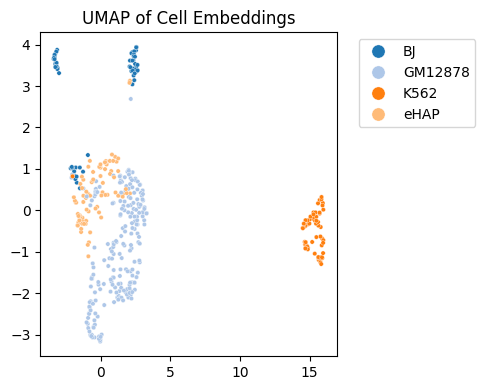

In [11]:
# === UMAP ===
model.eval()
cell_embed_matrix = []

with torch.no_grad():
    for inputs in data_loader_test:
        result = []
        inputs = [item.to(device) for item in inputs]
        x, attn_mask, all_patches, token_class = model.forward_encoder(inputs)
        chr_cls_index = np.where(token_class == 1)[0]
        chr_cls_tokens = x[:,chr_cls_index, :]
        chr_cls_tokens = chr_cls_tokens.view(chr_cls_tokens.shape[0], -1)
        cell_embed = model.latent_layer(chr_cls_tokens)
        cell_embed = model.pred_hidden(cell_embed)
        cell_embed = torch.nn.functional.gelu(cell_embed)
        cell_embed = np.squeeze(cell_embed.cpu().numpy())
        cell_embed_matrix.append(cell_embed)
cell_embed_matrix = np.vstack(cell_embed_matrix)


latent_cell_matrix = np.vstack(cell_embed_matrix)


from sklearn.preprocessing import StandardScaler
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns

scaler = StandardScaler()
latent_std = scaler.fit_transform(latent_cell_matrix)
umap_result = UMAP(n_components=2, random_state=42).fit_transform(latent_std)

# 绘图
plt.figure(figsize=(5,4))
sorted_categories = sorted(set(labels))
color_list = sns.color_palette("tab20", n_colors=len(sorted_categories))
sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], s=10,
                hue=labels, hue_order=sorted_categories, palette=color_list)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=3)
plt.title('UMAP of Cell Embeddings')
plt.tight_layout()
plt.show()
